In [10]:
%matplotlib inline

import warnings
import os
from datetime import datetime
from pathlib import Path
import quandl
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import graphviz

from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.externals import joblib
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, precision_recall_curve

In [11]:
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
idx = pd.IndexSlice
np.random.seed(42)

## Prepare Data

### Get source

In [12]:
def get_data(start='2000', end='2018', task='classification', holding_period=1, dropna=False):
    
    idx = pd.IndexSlice
    target = f'target_{holding_period}m'
    with pd.HDFStore('../00_data/data.h5') as store:
        df = store['data']

    if start is not None and end is not None:
        df = df.loc[idx[:, start: end], :]
    if dropna:
        df = df.dropna()
        
    y = (df[target]>0).astype(int)
    X = df.drop([c for c in df.columns if c.startswith('target')], axis=1)
    return y, X

### Factorize Categories

In [13]:
cat_cols = ['year', 'month', 'age', 'msize', 'sector']

In [14]:
def factorize_cats(df, cats=['sector']):
    cat_cols = ['year', 'month', 'age', 'msize'] + cats
    for cat in cats:
        df[cat] = pd.factorize(df[cat])[0]
    df.loc[:, cat_cols] = df.loc[:, cat_cols].fillna(-1)
    return df

### One-Hot Encoding

In [15]:
def get_one_hot_data(df, cols=cat_cols[:-1]):
    df = pd.get_dummies(df,
                        columns=cols + ['sector'],
                        prefix=cols + [''],
                        prefix_sep=['_'] * len(cols) + [''])
    return df.rename(columns={c: c.replace('.0', '') for c in df.columns})

### Get Holdout Set

In [16]:
def get_holdout_set(target, features, period=6):
    idx = pd.IndexSlice
    label = target.name
    dates = np.sort(y.index.get_level_values('date').unique())
    cv_start, cv_end = dates[0], dates[-period - 2]
    holdout_start, holdout_end = dates[-period - 1], dates[-1]

    df = features.join(target.to_frame())
    train = df.loc[idx[:, cv_start: cv_end], :]
    y_train, X_train = train[label], train.drop(label, axis=1)

    test = df.loc[idx[:, holdout_start: holdout_end], :]
    y_test, X_test = test[label], test.drop(label, axis=1)
    return y_train, X_train, y_test, X_test

## Load Data

In [17]:
y, features = get_data()
X_dummies = get_one_hot_data(features)
X_factors = factorize_cats(features)

In [18]:
y_clean, features_clean = get_data(dropna=True)
X_dummies_clean = get_one_hot_data(features_clean)
X_factors_clean = factorize_cats(features_clean)

## Cross-Validation Setup

### Custom Time Series KFold Generator

In [19]:
class OneStepTimeSeriesSplit:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the index contains a level labeled 'date'"""

    def __init__(self, n_splits=3, test_period_length=1, shuffle=False):
        self.n_splits = n_splits
        self.test_period_length = test_period_length
        self.shuffle = shuffle

    @staticmethod
    def chunks(l, n):
        for i in range(0, len(l), n):
            yield l[i:i + n]

    def split(self, X, y=None, groups=None):
        unique_dates = (X.index
                        .get_level_values('date')
                        .unique()
                        .sort_values(ascending=False)
                        [:self.n_splits*self.test_period_length])

        dates = X.reset_index()[['date']]
        for test_date in self.chunks(unique_dates, self.test_period_length):
            train_idx = dates[dates.date < min(test_date)].index
            test_idx = dates[dates.date.isin(test_date)].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [20]:
cv = OneStepTimeSeriesSplit(n_splits=12, test_period_length=1, shuffle=True)

### CV Metrics

In [21]:
metrics = {'balanced_accuracy': 'Accuracy' ,
           'roc_auc': 'AUC',
           'neg_log_loss': 'Log Loss',
           'f1_weighted': 'F1',
           'precision_weighted': 'Precision',
           'recall_weighted': 'Recall'
}

In [22]:
def run_cv(clf, X=X_dummies, y=y, metrics=metrics, cv=cv, fit_params=None):
    return cross_validate(estimator=clf,
                          X=X,
                          y=y,
                          scoring=list(metrics.keys()),
                          cv=cv,
                          return_train_score=True,
                          n_jobs=-1,
                          verbose=1,
                          fit_params=fit_params)

### CV Result Handler Functions

In [23]:
def stack_results(scores):
    columns = pd.MultiIndex.from_tuples(
        [tuple(m.split('_', 1)) for m in scores.keys()],
        names=['Dataset', 'Metric'])
    data = np.array(list(scores.values())).T
    df = (pd.DataFrame(data=data,
                       columns=columns)
          .iloc[:, 2:])
    results = pd.melt(df, value_name='Value')
    results.Metric = results.Metric.apply(lambda x: metrics.get(x))
    results.Dataset = results.Dataset.str.capitalize()
    return results

In [24]:
def plot_result(df, model=None):
    m = list(metrics.values())
    g = sns.catplot(x='Dataset', 
                    y='Value', 
                    hue='Dataset', 
                    col='Metric',
                    data=df, 
                    col_order=m,
                    order=['Train', 'Test'],
                    kind="box", 
                    col_wrap=3,
                    sharey=False,
                    height=4, aspect=1.2)
    df = df.groupby(['Metric', 'Dataset']).Value.mean().unstack().loc[m]
    for i, ax in enumerate(g.axes.flat):
        s = f"Train: {df.loc[m[i], 'Train']:>7.4f}\nTest:  {df.loc[m[i], 'Test'] :>7.4f}"
        ax.text(0.05, 0.85, s, fontsize=10, transform=ax.transAxes, 
                bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.5'))
    g.fig.suptitle(model, fontsize=16)
    g.fig.subplots_adjust(top=.9);

## Baseline Classifier

In [25]:
dummy_clf = DummyClassifier(strategy='stratified',
                            random_state=42)

In [26]:
fname = 'results/dummy_cv_result.joblib'
if not Path(fname).exists():
    dummy_cv_result = run_cv(dummy_clf)
    joblib.dump(dummy_cv_result, fname)
else:
    dummy_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    3.6s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    3.7s finished


In [27]:
dummy_result = stack_results(dummy_cv_result)
dummy_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.494516,0.499862
Accuracy,0.494516,0.499862
F1,0.501068,0.502171
Log Loss,-17.594264,-17.195080
Precision,0.534767,0.502186
Recall,0.490601,0.502157


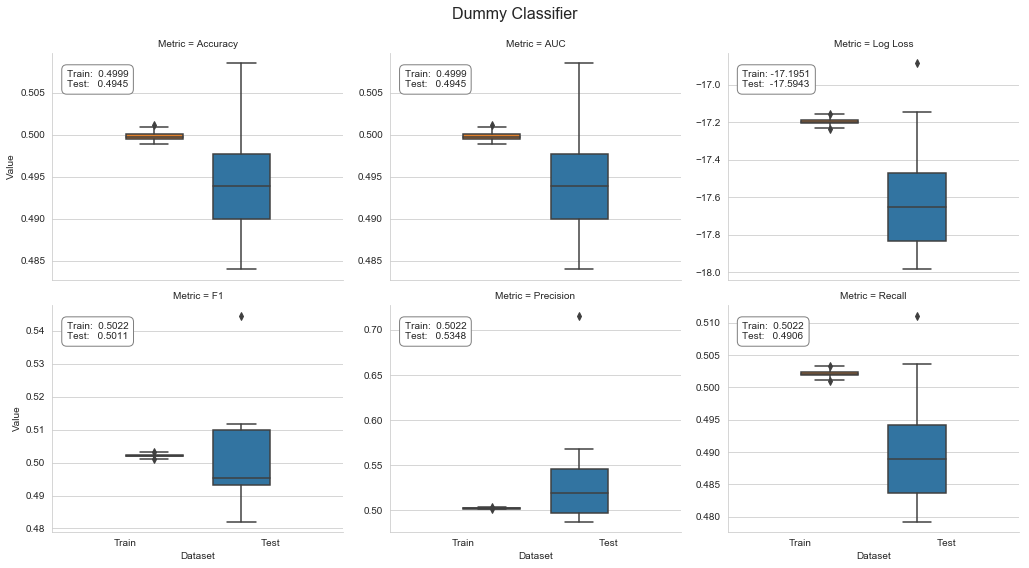

In [28]:
plot_result(dummy_result, model='Dummy Classifier')

## RandomForest

### Configure

In [29]:
rf_clf = RandomForestClassifier(n_estimators=200,             # will change from 10 to 100 in version 0.22 
                                criterion='gini', 
                                max_depth=None, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto',
                                max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                min_impurity_split=None, 
                                bootstrap=True, 
                                oob_score=True, 
                                n_jobs=-1,
                                random_state=42, 
                                verbose=1)

### Cross-validate

In [30]:
fname = 'results/rf_cv_result.joblib'
if not Path(fname).exists():
    rf_cv_result = run_cv(rf_clf, y=y_clean, X=X_dummies_clean)
    joblib.dump(rf_cv_result, fname)
else:
    rf_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed: 28.2min remaining:  5.6min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 28.3min finished


### Plot Results

In [31]:
rf_result = stack_results(rf_cv_result)
rf_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.663097,1.000000
Accuracy,0.611702,1.000000
F1,0.585762,1.000000
Log Loss,-0.611707,-0.169468
Precision,0.661679,1.000000
Recall,0.597694,1.000000


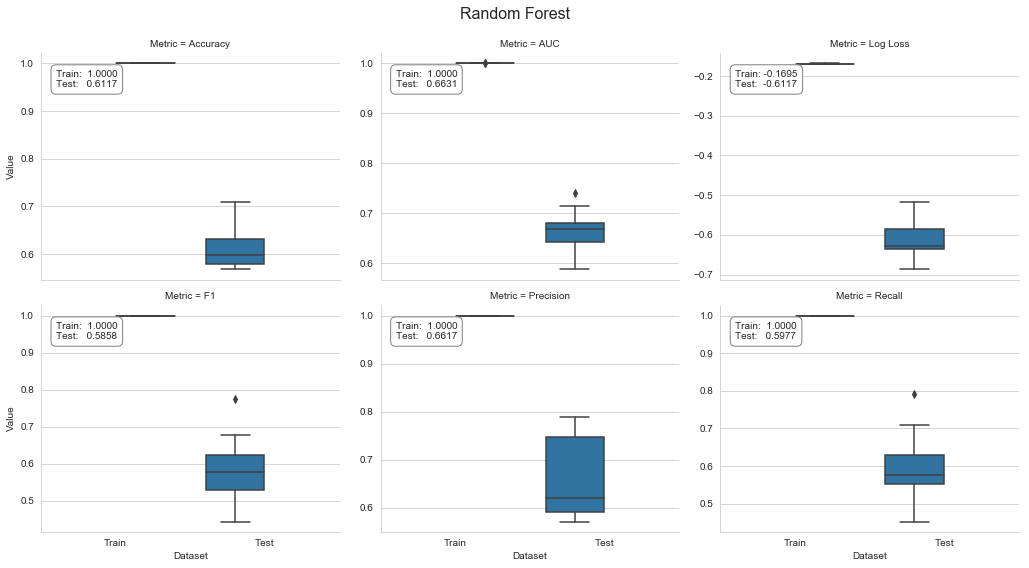

In [32]:
plot_result(rf_result, model='Random Forest')

## sklearn: AdaBoost

### Base Estimator

In [33]:
base_estimator = DecisionTreeClassifier(criterion='gini', 
                                        splitter='best',
                                        max_depth=1, 
                                        min_samples_split=2, 
                                        min_samples_leaf=20, 
                                        min_weight_fraction_leaf=0.0,
                                        max_features=None, 
                                        random_state=None, 
                                        max_leaf_nodes=None, 
                                        min_impurity_decrease=0.0, 
                                        min_impurity_split=None, 
                                        class_weight=None, 
                                        presort=False)

### AdaBoost Configuration

In [34]:
ada_clf = AdaBoostClassifier(base_estimator=base_estimator,
                             n_estimators=200,
                             learning_rate=1.0,
                             algorithm='SAMME.R',
                             random_state=42)

### Cross-validate

In [35]:
fname = 'results/ada_cv_result.joblib'
if not Path(fname).exists():
    ada_cv_result = run_cv(ada_clf, y=y_clean, X=X_dummies_clean)
    joblib.dump(ada_cv_result, fname)
else:
    ada_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed: 15.2min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 15.3min finished


### Plot Result

In [36]:
ada_result = stack_results(ada_cv_result)
ada_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.666527,0.613429
Accuracy,0.623796,0.574583
F1,0.587645,0.574731
Log Loss,-0.692297,-0.692876
Precision,0.704315,0.585420
Recall,0.617226,0.587676


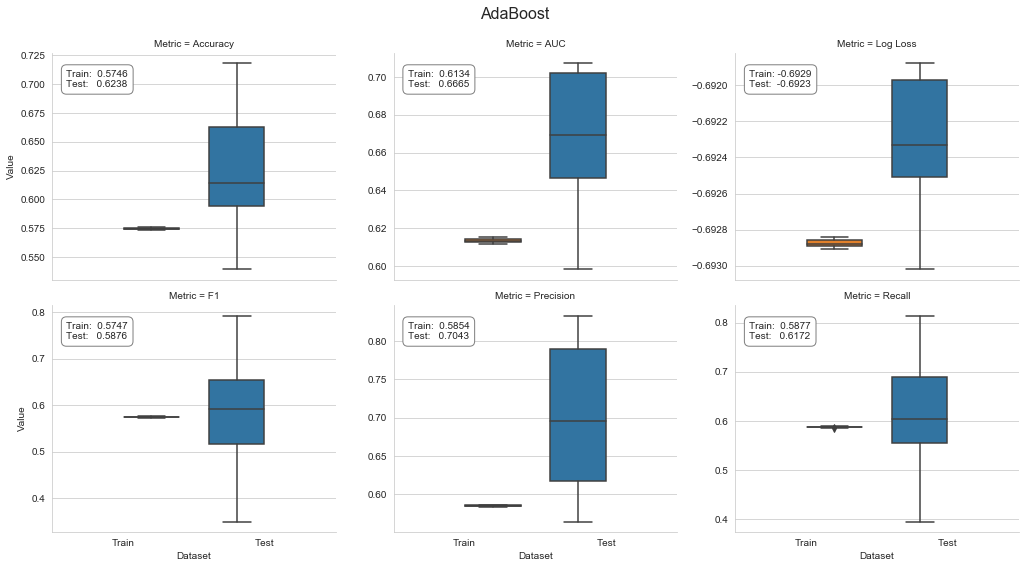

In [37]:
plot_result(ada_result, model='AdaBoost')

## sklearn: GradientBoostingClassifier

### Configure

In [38]:
gb_clf = GradientBoostingClassifier(loss='deviance',                # deviance = logistic reg; exponential: AdaBoost
                                    learning_rate=0.1,              # shrinks the contribution of each tree
                                    n_estimators=100,               # number of boosting stages
                                    subsample=1.0,                  # fraction of samples used t fit base learners
                                    criterion='friedman_mse',       # measures the quality of a split
                                    min_samples_split=2,            
                                    min_samples_leaf=1, 
                                    min_weight_fraction_leaf=0.0,   # min. fraction of sum of weights
                                    max_depth=3,                    # opt value depends on interaction
                                    min_impurity_decrease=0.0, 
                                    min_impurity_split=None, 
                                    init=None, 
                                    random_state=None, 
                                    max_features=None, 
                                    verbose=0, 
                                    max_leaf_nodes=None, 
                                    warm_start=False, 
                                    presort='auto', 
                                    validation_fraction=0.1, 
                                    n_iter_no_change=None, 
                                    tol=0.0001)

### Cross-validate

In [39]:
fname = 'results/gb_cv_result.joblib'
if not Path(fname).exists():
    gb_cv_result = run_cv(gb_clf, y=y_clean, X=X_dummies_clean)
    joblib.dump(gb_cv_result, fname)
else:
    gb_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed: 13.3min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 13.4min finished


### Plot Results

In [40]:
gb_result = stack_results(gb_cv_result)
gb_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.676495,0.695657
Accuracy,0.628409,0.630696
F1,0.588042,0.632837
Log Loss,-0.627544,-0.638374
Precision,0.689281,0.645357
Recall,0.625437,0.642648


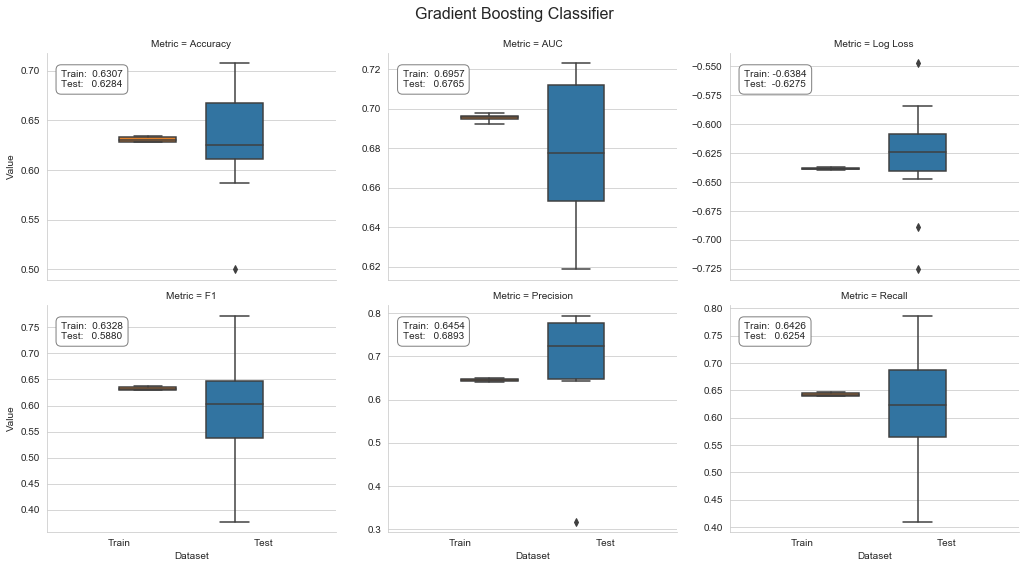

In [41]:
plot_result(gb_result, model='Gradient Boosting Classifier')

### Partial Dependence Plot

In [42]:
gb_clf.fit(y=y_clean, X=X_dummies_clean)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [43]:
# mean accuracy
gb_clf.score(X=X_dummies_clean, y=y_clean)

0.6403943215801232

In [44]:
y_score = gb_clf.predict_proba(X_dummies_clean)[:, 1]
roc_auc_score(y_score=y_score, y_true=y_clean)

0.6958215417089864

#### Feature Importance

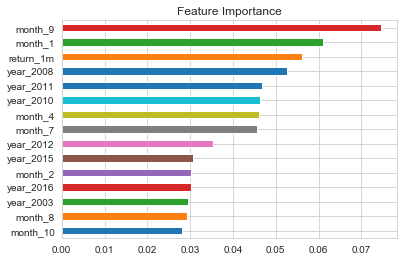

In [45]:
(pd.Series(gb_clf.feature_importances_, 
          index=X_dummies_clean.columns)
 .sort_values(ascending=False)
 .head(15)).sort_values().plot.barh(title='Feature Importance');

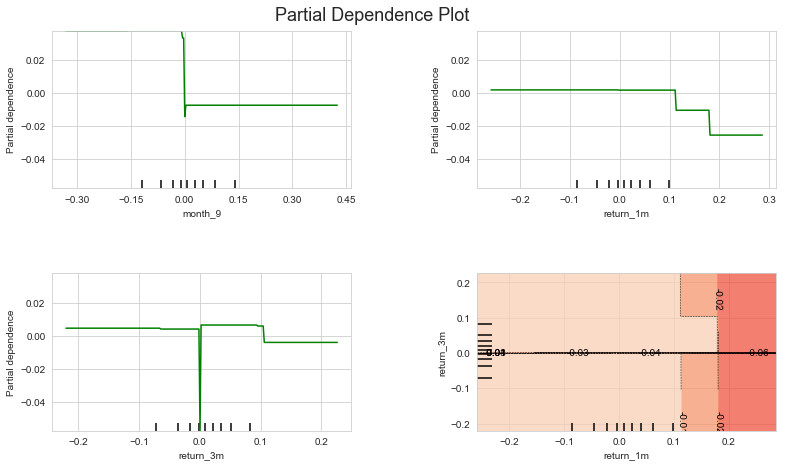

In [46]:
fig, axes = plot_partial_dependence(gbrt=gb_clf,
                                    X=X_dummies_clean,
                                    features=['month_9', 'return_1m', 'return_3m', ('return_1m', 'return_3m')],
                                    feature_names=['month_9','return_1m', 'return_3m'],
                                    percentiles=(0.01, 0.99),
                                    n_jobs=-1,
                                    n_cols=2,
                                    grid_resolution=250)
fig.suptitle('Partial Dependence Plot', fontsize=18)
fig.tight_layout()
fig.set_size_inches(12, 7)

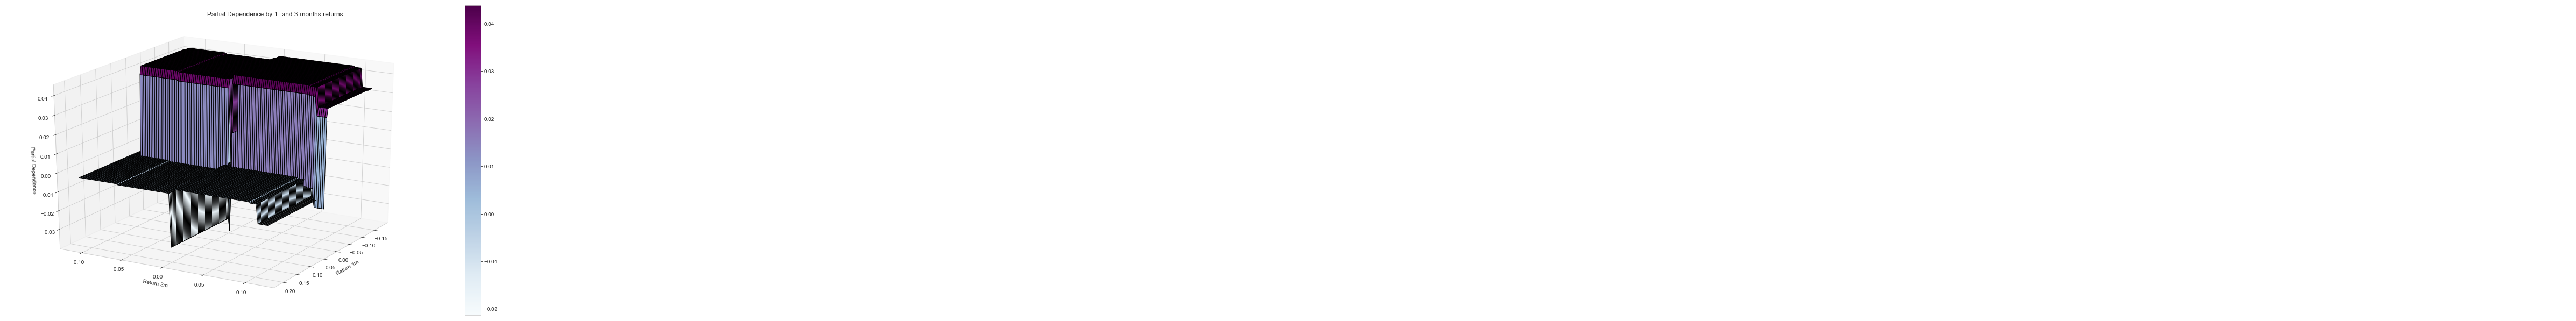

In [47]:
targets = ['return_1m', 'return_3m']
target_feature = [X_dummies_clean.columns.get_loc(t) for t in targets]
pdp, axes = partial_dependence(gb_clf,
                               target_feature,
                               X=X_dummies_clean,
                               grid_resolution=100)

XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T

fig = plt.figure(figsize=(14, 8))
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z,
                       rstride=1,
                       cstride=1,
                       cmap=plt.cm.BuPu,
                       edgecolor='k')
ax.set_xlabel(' '.join(targets[0].split('_')).capitalize())
ax.set_ylabel(' '.join(targets[1].split('_')).capitalize())
ax.set_zlabel('Partial Dependence')
ax.view_init(elev=22, azim=30)

fig.colorbar(surf)
fig.suptitle('Partial Dependence by 1- and 3-months returns')
fig.tight_layout()
fig.savefig('partial_plot', dpi=300);

## XGBoost

### Configure

In [48]:
xgb_clf = XGBClassifier(max_depth=3,                  # Maximum tree depth for base learners.
                        learning_rate=0.1,            # Boosting learning rate (xgb's "eta")
                        n_estimators=100,             # Number of boosted trees to fit.
                        silent=True,                  # Whether to print messages while running
                        objective='binary:logistic',  # Task and objective or custom objective function
                        booster='gbtree',             # Select booster: gbtree, gblinear or dart
                        tree_method='gpu_hist',
                        n_jobs=-1,                    # Number of parallel threads
                        gamma=0,                      # Min loss reduction for further splits
                        min_child_weight=1,           # Min sum of sample weight(hessian) needed
                        max_delta_step=0,             # Max delta step for each tree's weight estimation
                        subsample=1,                  # Subsample ratio of training samples
                        colsample_bytree=1,           # Subsample ratio of cols for each tree
                        colsample_bylevel=1,          # Subsample ratio of cols for each split
                        reg_alpha=0,                  # L1 regularization term on weights
                        reg_lambda=1,                 # L2 regularization term on weights
                        scale_pos_weight=1,           # Balancing class weights
                        base_score=0.5,               # Initial prediction score; global bias
                        random_state=42)              # random seed

### Cross-validate

In [49]:
fname = 'results/xgb_cv_result.joblib'
if not Path(fname).exists():
    xgb_cv_result = run_cv(xgb_clf)
    joblib.dump(xgb_cv_result, fname)
else:
    xgb_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   38.3s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   38.7s finished


### Plot Results

In [50]:
xbg_result = stack_results(xgb_cv_result)
xbg_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.685713,0.689572
Accuracy,0.619728,0.624121
F1,0.561358,0.624078
Log Loss,-0.593554,-0.639261
Precision,0.697099,0.640137
Recall,0.584871,0.635572


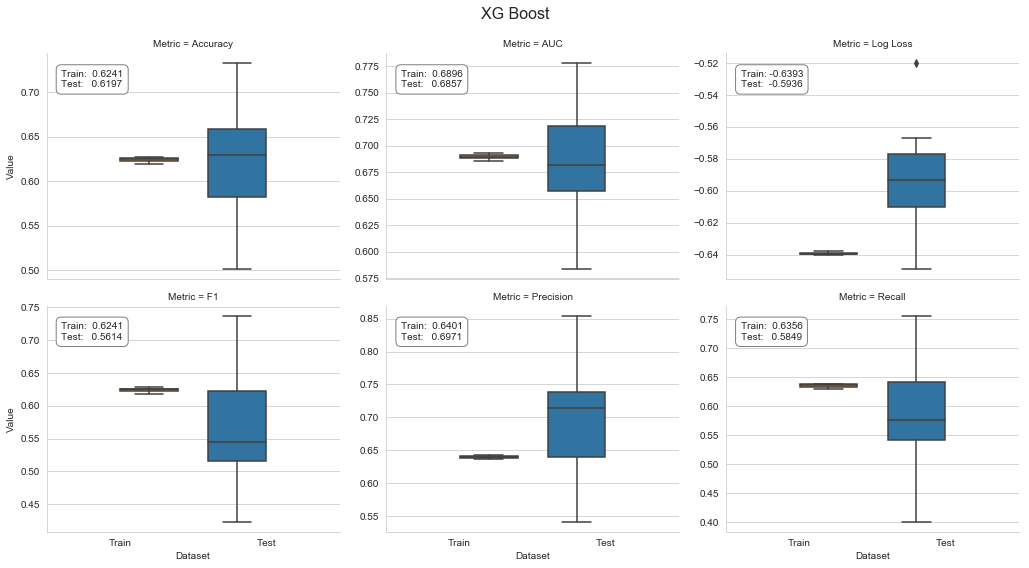

In [51]:
plot_result(xbg_result, model='XG Boost')

In [52]:
xgb_clf.fit(X=X_dummies, y=y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1, tree_method='gpu_hist')

In [53]:
fi = pd.Series(xgb_clf.feature_importances_, index=X_dummies.columns)

In [54]:
fi[fi>0].sort_values(ascending=False)

month_9          0.050000
month_1          0.047143
year_2011        0.041429
return_12m       0.038571
year_2009        0.038571
year_2010        0.030000
month_2          0.030000
year_2008        0.028571
month_3          0.028571
msize_-1         0.028571
return_1m_t-2    0.027143
year_2003        0.027143
year_2018        0.027143
return_1m        0.027143
month_7          0.027143
month_10         0.025714
month_4          0.022857
year_2007        0.022857
momentum_3       0.021429
year_2002        0.021429
year_2015        0.020000
year_2014        0.020000
month_11         0.020000
return_1m_t-5    0.018571
month_6          0.018571
month_8          0.018571
year_2005        0.018571
year_2012        0.018571
return_1m_t-1    0.018571
Mkt-RF           0.014286
month_12         0.014286
year_2016        0.014286
year_2017        0.014286
year_2013        0.012857
month_5          0.011429
return_6m        0.011429
return_3m        0.010000
return_9m        0.008571
momentum_9  

## LightGBM

### Configure

In [55]:
lgb_clf = LGBMClassifier(boosting_type='gbdt',
                         device='gpu',
                         objective='binary',          # learning task
                         metric='auc',
                         num_leaves=31,               # Maximum tree leaves for base learners.
                         max_depth=-1,                # Maximum tree depth for base learners, -1 means no limit.
                         learning_rate=0.1,          # Adaptive lr via callback override in .fit() method  
                         n_estimators=100,            # Number of boosted trees to fit
                         subsample_for_bin=200000,    # Number of samples for constructing bins.
                         class_weight=None,           # dict, 'balanced' or None
                         min_split_gain=0.0,          # Minimum loss reduction for further split
                         min_child_weight=0.001,      # Minimum sum of instance weight(hessian)
                         min_child_samples=20,        # Minimum number of data need in a child(leaf)
                         subsample=1.0,               # Subsample ratio of training samples
                         subsample_freq=0,            # Frequency of subsampling, <=0: disabled
                         colsample_bytree=1.0,        # Subsampling ratio of features
                         reg_alpha=0.0,               # L1 regularization term on weights
                         reg_lambda=0.0,              # L2 regularization term on weights
                         random_state=42,             # Random number seed; default: C++ seed
                         n_jobs=-1,                   # Number of parallel threads.
                         silent=False,
                         importance_type='gain',      # default: 'split' or 'gain'
#                          feature_fraction=1,
                        )

### Cross-Validate

#### Using categorical features

In [56]:
fname = 'results/lgb_factor_cv_result.joblib'
if not Path(fname).exists():
    lgb_factor_cv_result = run_cv(lgb_clf, X=X_factors, fit_params={'categorical_feature': cat_cols})
    joblib.dump(lgb_factor_cv_result, fname)
else:
    lgb_factor_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  1.0min remaining:   12.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.0min finished


##### Plot Results

In [57]:
lgb_factor_result = stack_results(lgb_factor_cv_result)
lgb_factor_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.687674,0.754115
Accuracy,0.585246,0.683016
F1,0.523911,0.686125
Log Loss,-0.605207,-0.586802
Precision,0.600335,0.692754
Recall,0.566841,0.690457


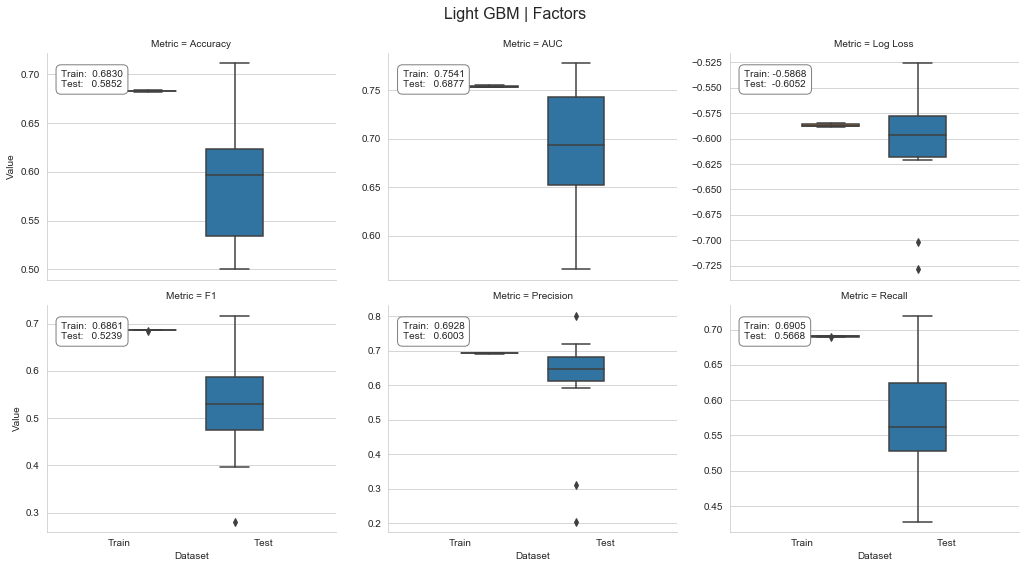

In [58]:
plot_result(lgb_factor_result, model='Light GBM | Factors')

#### Using dummy variables

In [59]:
fname = 'results/lgb_dummy_cv_result.joblib'
if not Path(fname).exists():
    lgb_dummy_cv_result = run_cv(lgb_clf)
    joblib.dump(lgb_dummy_cv_result, fname)
else:
    lgb_dummy_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   53.6s remaining:   10.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   53.7s finished


##### Plot results

In [60]:
lgb_dummy_result = stack_results(lgb_dummy_cv_result)
lgb_dummy_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.688091,0.747578
Accuracy,0.625765,0.676239
F1,0.569837,0.678779
Log Loss,-0.582720,-0.594452
Precision,0.673326,0.690508
Recall,0.598393,0.685434


## Catboost

### Configure

In [61]:
cat_clf = CatBoostClassifier(iterations=500, 
                             learning_rate=0.03, 
                             depth=6, 
                             l2_leaf_reg=3, 
                             model_size_reg=None, 
                             rsm=None,                             # Subsample ratio of columns
                             loss_function='Logloss', 
                             border_count=32,                      # number of partitions for Num feature
                             feature_border_type='MinEntropy',     # Type of binarization target (for regression)
#                              fold_permutation_block_size=1,        # To accelerate the learning
                             od_pval=None,                         # overfitting detector to stop training
                             od_wait=None,                         # No iterations od will wait
                             od_type=None,                         # Type of overfitting detector
                             nan_mode='Min',                       # treat missing values as min [max, forbidden]
                             counter_calc_method=None,             # 
                             leaf_estimation_iterations=1, 
                             leaf_estimation_method='Gradient', 
                             thread_count=None,                    # None: no of cores
                             random_seed=None,              
                             use_best_model=None, 
                             best_model_min_trees=None, 
                             verbose=100, 
                             logging_level='Verbose',  
                             metric_period=1, 
                             simple_ctr=None,                      # Binarization settings for categorical features
                             ctr_leaf_count_limit=None, 
                             store_all_simple_ctr=None, 
                             max_ctr_complexity=1, 
                             has_time=None, 
                             allow_const_label=None, 
                             classes_count=None, 
                             class_weights=None, 
                             one_hot_max_size=None,                # Convert the feature to float
                             random_strength=None, 
                             name=None, 
                             ignored_features=None, 
                             train_dir=None, 
                             custom_loss=None, 
                             custom_metric=None,
                             eval_metric='AUC', 
                             bagging_temperature=None, 
                             save_snapshot=None, 
                             snapshot_file=None, 
                             snapshot_interval=None, 
                             fold_len_multiplier=None, 
                             used_ram_limit=None, 
                             gpu_ram_part=.2, 
                             pinned_memory_size=None, 
                             allow_writing_files=None, 
                             final_ctr_computation_mode=None, 
                             approx_on_full_history=None, 
                             boosting_type=None, 
                             combinations_ctr=None, 
                             per_feature_ctr=None, 
                             ctr_description=None, 
                             task_type='GPU', 
                             bootstrap_type='Bayesian', 
                             subsample=None, 
                             dev_score_calc_obj_block_size=None, 
                             gpu_cat_features_storage=None, 
                             data_partition=None, 
                             metadata=None, 
                             early_stopping_rounds=None,
                             cat_features=None)

### Cross-Validate

In [62]:
s = pd.Series(X_factors.columns.tolist())
cat_cols_idx = s[s.isin(cat_cols)].index.tolist()

In [63]:
fname = 'results/cat_cv_result.joblib'
if not Path(fname).exists():
    cat_cv_result = run_cv(cat_clf, X=X_factors, fit_params={'cat_features': cat_cols_idx})
    joblib.dump(cat_cv_result, fname)
else:
    cat_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  1.8min remaining:   21.3s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.8min finished


### Plot Results

In [64]:
cat_result = stack_results(cat_cv_result)
cat_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.692744,0.681260
Accuracy,0.577465,0.618769
F1,0.489477,0.617526
Log Loss,-0.641736,-0.644103
Precision,0.548202,0.636981
Recall,0.564361,0.631153


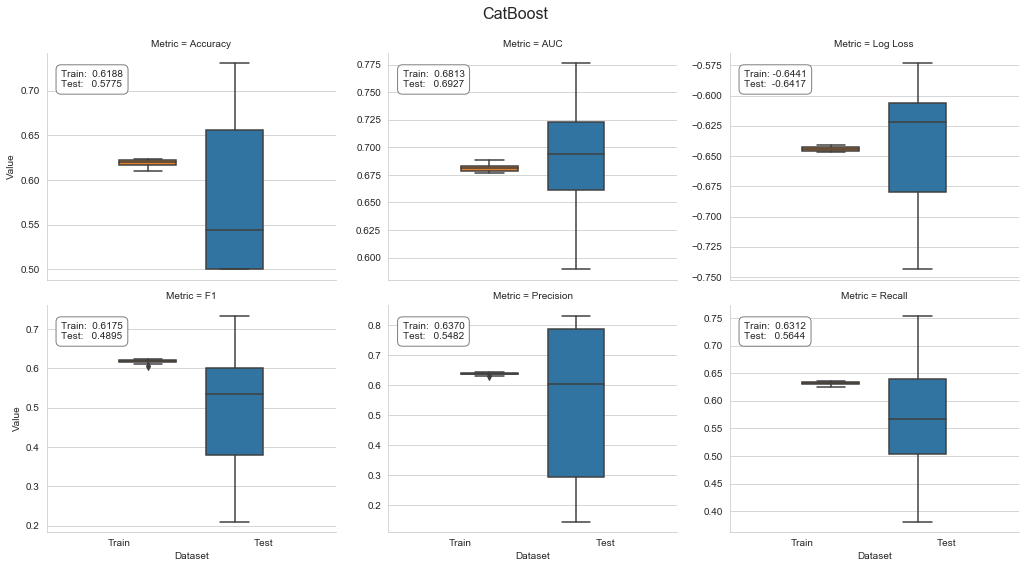

In [65]:
plot_result(cat_result, model='CatBoost')

## Compare Results

In [72]:
results = {'Baseline': dummy_result,
           'Random Forest': rf_result,
           'AdaBoost': ada_result,
           'Gradient Booster': gb_result,
           'XG Boost': xbg_result,
           'LightGBM Dummies': lgb_dummy_result,
           'LightGBM Factors': lgb_factor_result,
           'CatBoost': cat_result}
df = pd.DataFrame()
for model, result in results.items():
    df = pd.concat([df, result.groupby(['Metric', 'Dataset']
                                       ).Value.mean().unstack()['Test'].to_frame(model)], axis=1)

df.T.sort_values('AUC', ascending=False)

Metric,AUC,Accuracy,F1,Log Loss,Precision,Recall
CatBoost,0.692744,0.577465,0.489477,-0.641736,0.548202,0.564361
LightGBM Dummies,0.688091,0.625765,0.569837,-0.582720,0.673326,0.598393
LightGBM Factors,0.687674,0.585246,0.523911,-0.605207,0.600335,0.566841
XG Boost,0.685713,0.619728,0.561358,-0.593554,0.697099,0.584871
Gradient Booster,0.676495,0.628409,0.588042,-0.627544,0.689281,0.625437
AdaBoost,0.666527,0.623796,0.587645,-0.692297,0.704315,0.617226
Random Forest,0.663097,0.611702,0.585762,-0.611707,0.661679,0.597694
Baseline,0.494516,0.494516,0.501068,-17.594264,0.534767,0.490601


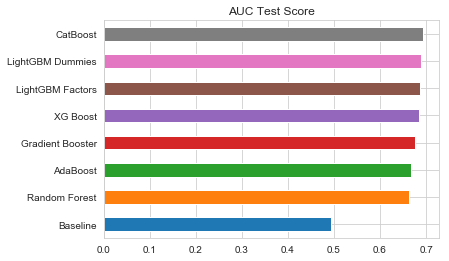

In [73]:
df.T['AUC'].sort_values().plot.barh(title='AUC Test Score');

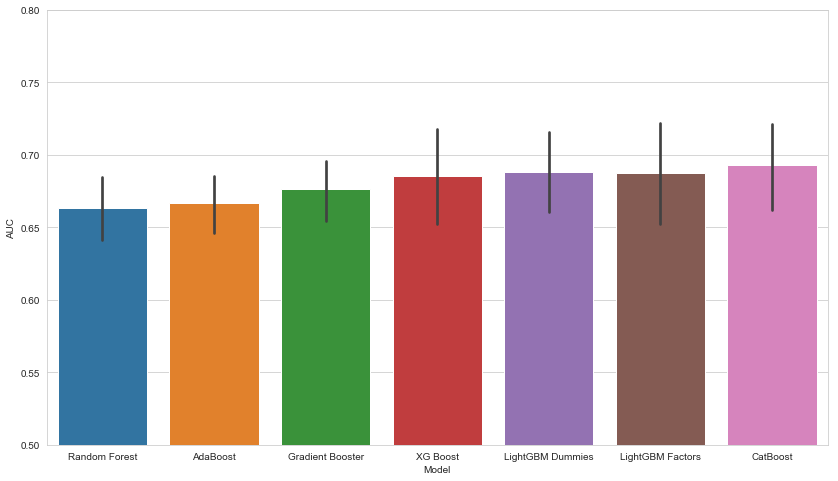

In [84]:
fig, ax = plt.subplots(figsize=(14, 8))
auc = pd.concat([v.loc[(v.Dataset=='Test') & (v.Metric=='AUC'), 'Value'].to_frame('AUC').assign(Model=k) 
                 for k, v in results.items()])
auc = auc[auc.Model != 'Baseline']
sns.barplot(x='Model', y='AUC', data=auc, ax=ax)
ax.set_ylim(.5, .8);